In [1]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############
from collections import OrderedDict
import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import sqrt
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
#from macro_sql import Q076 
with open('quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [2]:
#load single bank data as dataframe
bank_df = pd.read_csv('dist_csvs/income_to_amount_dist__bank.csv')
inc_df = bank_df.copy() # split income df out to sort values by income for graphing cumulative income percent
#these data are for single family, conventional, owner occupied, first lien, home purchase loans at the national level
#other analysis will be used for each loan product, lien status, geography, and other variables as appropriate

In [3]:
#sort data frame by amount field, this is useful because multiple years are present
bank_df.sort_values(by='amount', inplace=True)
inc_df.sort_values(by='income', inplace=True)
inc_df.head()

,year,income,amount
0,2014,1,88
229447,2011,1,10
156483,2012,1,50
76159,2013,1,8
76160,2013,1,16


In [133]:
#bank_df = bank_df[bank_df.year == 2014].copy() #select single year
bank_df.income = bank_df.income.map(int) #convert data to numeric
bank_df.amount = bank_df.amount.map(int) #convert data to numeric
bank_df['mult'] = bank_df.amount/bank_df.income #create amount to income multiple

#create percent and cumulative percents by value
bank_df['pct_amt'] = bank_df['amount']/bank_df['amount'].sum() #calculate percent of total amount for each row
bank_df['cumul_amt_pct'] = bank_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
bank_df['pct_inc'] = bank_df['income']/bank_df['income'].sum()
bank_df['cumul_inc_pct'] = bank_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
cnt_amt_df = pd.DataFrame(bank_df.groupby(['amount']).pct_amt.count())
cnt_amt_df.rename(columns={'pct_amt':'count_amt'}, inplace=True)
cnt_amt_df['amount'] = cnt_amt_df.index
cnt_amt_df['pct_of_cnt'] = cnt_amt_df.count_amt.divide(other=cnt_amt_df.count_amt.sum())
cnt_amt_df['cumul_pct_cnt'] = cnt_amt_df.pct_of_cnt.cumsum()

#create percent and cumulative percents by value
inc_df['pct_amt'] = inc_df['amount']/inc_df['amount'].sum() #calculate percent of total amount for each row
inc_df['cumul_amt_pct'] = inc_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
inc_df['pct_inc'] = inc_df['income']/inc_df['income'].sum()
inc_df['cumul_inc_pct'] = inc_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
total = inc_df.groupby(['income']).pct_inc.count().sum()

#create percent and cumulative percents by count and count times amount
cnt_inc_df = pd.DataFrame(inc_df.groupby(['income']).pct_inc.count())
cnt_inc_df.rename(columns={'pct_inc':'count_inc'}, inplace=True)
cnt_inc_df['income'] = cnt_inc_df.index
cnt_inc_df['pct_of_cnt'] = cnt_inc_df.count_inc.divide(other=cnt_inc_df.count_inc.sum())
cnt_inc_df['cumul_pct_cnt'] = cnt_inc_df.pct_of_cnt.cumsum()


In [7]:
print(bank_df.head()) #check dataframe for columns
print(inc_df.head())

       year  income  amount      mult       pct_amt  cumul_amt_pct   pct_inc  \
7036   2014      56       7  0.125000  1.892840e-07   1.892840e-07  0.000004   
9916   2014      67       8  0.119403  2.163245e-07   4.056085e-07  0.000004   
1090   2014      25       8  0.320000  2.163245e-07   6.219331e-07  0.000002   
1468   2014      28       9  0.321429  2.433651e-07   8.652982e-07  0.000002   
33498  2014     140      10  0.071429  2.704057e-07   1.135704e-06  0.000009   

       cumul_inc_pct  
7036        0.000004  
9916        0.000008  
1090        0.000009  
1468        0.000011  
33498       0.000020  
        year  income  amount       pct_amt  cumul_amt_pct       pct_inc  \
0       2014       1      88  6.783152e-07   6.783152e-07  1.704434e-08   
229447  2011       1      10  7.708127e-08   7.553965e-07  1.704434e-08   
156483  2012       1      50  3.854064e-07   1.140803e-06  1.704434e-08   
76159   2013       1       8  6.166502e-08   1.202468e-06  1.704434e-08   
76160 

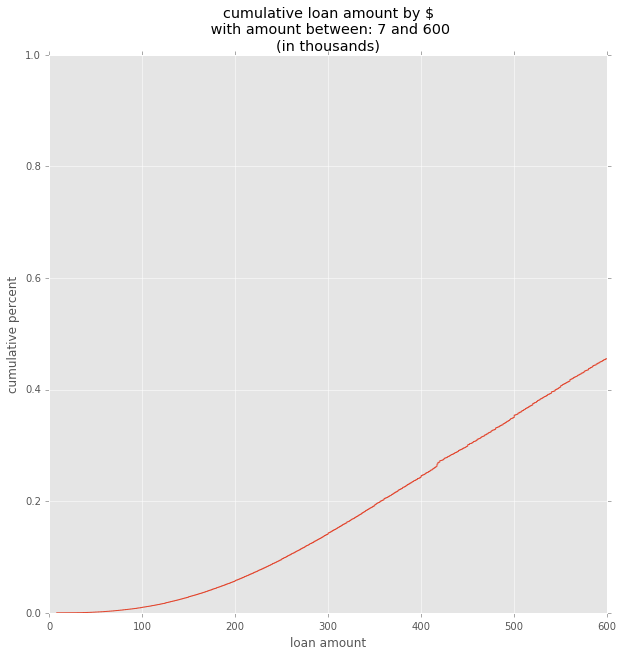

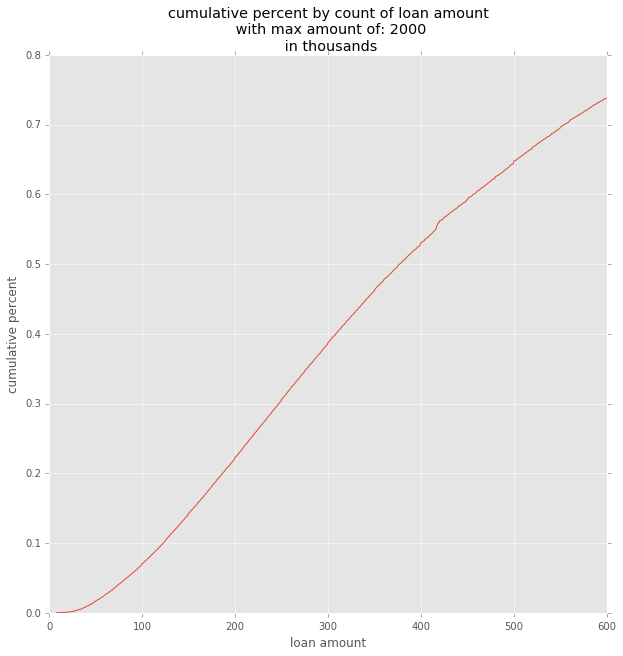

In [98]:
#FIXME add cutoff field name and cutoff value to title
#graph cumulative sum of % of income and % of loan amount 
amt_min = bank_df.amount.min()
amt_max = 600#bank_df.amount.max()

y = bank_df.cumul_amt_pct[(bank_df.amount < amt_max) & (bank_df.amount > amt_min)]
x = bank_df.amount[(bank_df.amount < amt_max) & (bank_df.amount > amt_min)]
cumul_pct = plt.figure(figsize=(10,10))
plt.plot(x,y)
ax = plt.subplot()
ax.set_ylim([0,1])
plt.title('cumulative loan amount by $\n with amount between: {amt_min} and {amt_max}\n(in thousands)'.format(amt_min=amt_min, amt_max=amt_max))
plt.ylabel('cumulative percent')
plt.xlabel('loan amount')
plt.show(cumul_pct)

#y1 = bank_df.cumul_cnt_pct_amt[bank_df[cut_field] < amt_cutoff]
x1 = cnt_amt_df.amount[(cnt_amt_df.amount < amt_max) & (cnt_amt_df.amount > amt_min)]
y1 = cnt_amt_df.cumul_pct_cnt[(cnt_amt_df.amount < amt_max) & ( cnt_amt_df.amount > amt_min)]
cumul_cnt = plt.figure(figsize=(10,10))
plt.plot(x1,y1)
plt.xlabel('loan amount')
plt.ylabel('cumulative percent')
plt.title('cumulative percent by count of loan amount\n with max amount of: {amt}\n in thousands'.format(amt=amt_cutoff))
plt.show(cumul_cnt)


#FIXME modify these graphs by reducing the range of the x axis to see the cumulative curve better
#measureing the $ value of loans shows a high degree of skew due to very large loan amounts
#cutting the tail off the data may be more informative
#the majority of loans by count are under 450-500k, but the raw $ value majority is closer to 2million

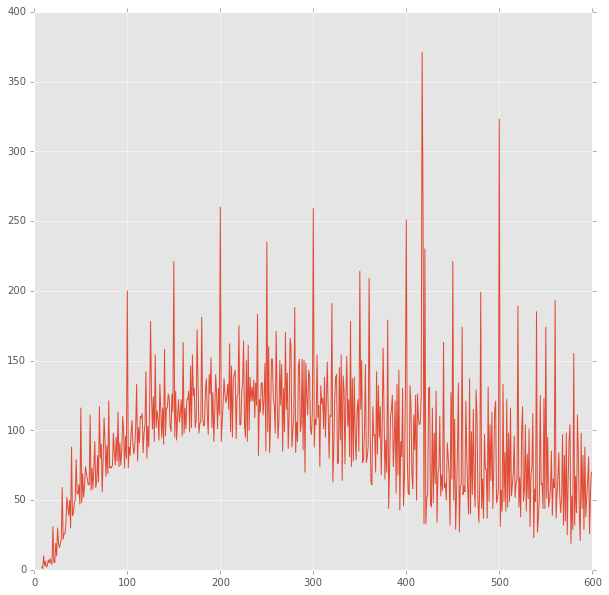

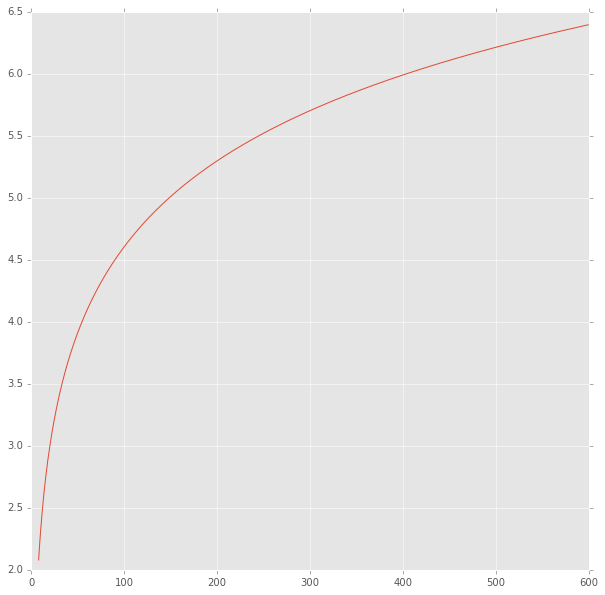

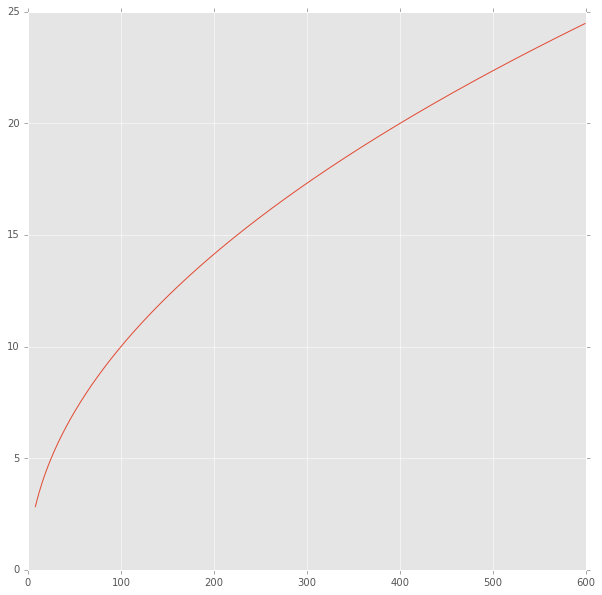

In [100]:
from math import log, sqrt
amt_dist = pd.DataFrame(bank_df.groupby('amount').mult.count())
amt_dist.rename(columns={'mult':'count_amt'},inplace=True)
amt_dist['amount'] = amt_dist.index
amt_dist['amt_log'] = amt_dist.amount.apply(log)
amt_dist['amt_sqrt'] = amt_dist.amount.apply(sqrt)
amt_dist.head()
amt_fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
amt_y1 = amt_dist.count_amt[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]
amt_x1 = amt_dist.amount[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]


plt.plot(amt_x1,amt_y1)
plt.show(amt_fig)

#plot logs of amount
log_fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
amt_y2 = amt_dist.amt_log[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]
plt.plot(amt_x1,amt_y2)
plt.show(log_fig)

#plot sqrt of amount
sqrt_fig = plt.figure(figsize=(10,10))
amt_y3 = amt_dist.amt_sqrt[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]
plt.plot(amt_x1,amt_y3)
plt.show(sqrt_fig)



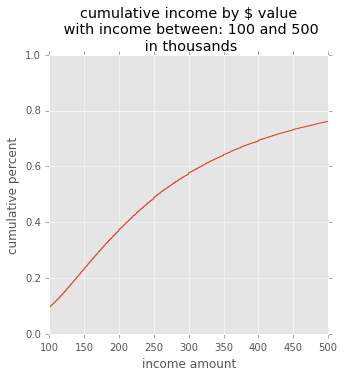

In [26]:
#showing cumulative percent of count of loans by income
#inc_cutoff allows trims max end of distribution
inc_min = 100
inc_max = 500
y = inc_df.cumul_inc_pct[(inc_df.income < inc_max) & (inc_df.income > inc_min)]
x = inc_df.income[(inc_df.income < inc_max) &(inc_df.income > inc_min)]

cumul_inc = plt.figure(figsize=(5,5))
plt.plot(x,y)
ax = plt.subplot()
ax.set_ylim([0,1])
plt.title('cumulative income by $ value\n with income between: {inc_min} and {inc_max}\n in thousands'.format(inc_min=inc_min, inc_max=inc_max))
plt.ylabel('cumulative percent')
plt.xlabel('income amount')
plt.show(cumul_inc)


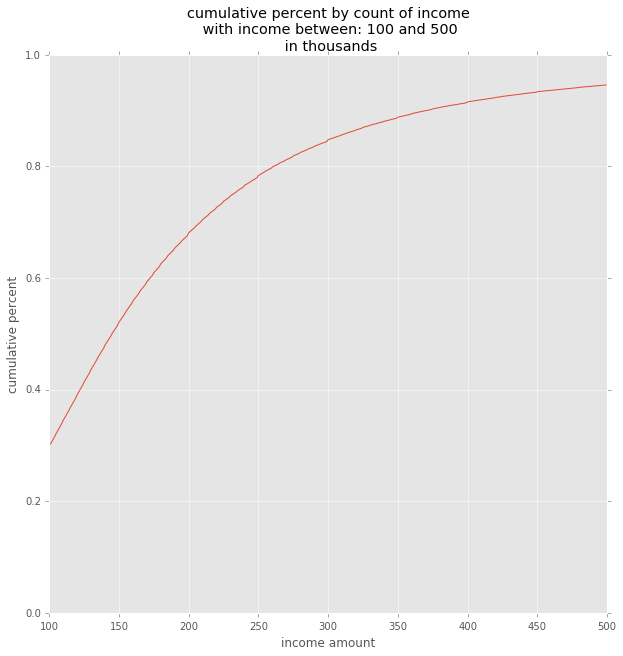

In [27]:
x1 = cnt_inc_df.income[(cnt_inc_df.income < inc_max) & (cnt_inc_df.income > inc_min)]
y1 = cnt_inc_df.cumul_pct_cnt[(cnt_inc_df.income < inc_max) & (cnt_inc_df.income > inc_min)]
cumul_cnt = plt.figure(figsize=(10,10))
plt.plot(x1,y1)
ax = plt.subplot()
ax.set_ylim([0,1])
plt.xlabel('income amount')
plt.ylabel('cumulative percent')
plt.title('cumulative percent by count of income\n with income between: {inc_min} and {inc_max}\n in thousands'.format(inc_min=inc_min, inc_max=inc_max))
plt.show(cumul_cnt)

437.434185441 std
485.58242624 mean
377.0 median
2500.0 max mult
0.0352564102564 min mult
1720.0 98%
612.0 q3
217.0 q1
55.0 02%
395.0 iqr
-375.5 min_q 1204.5 max_q


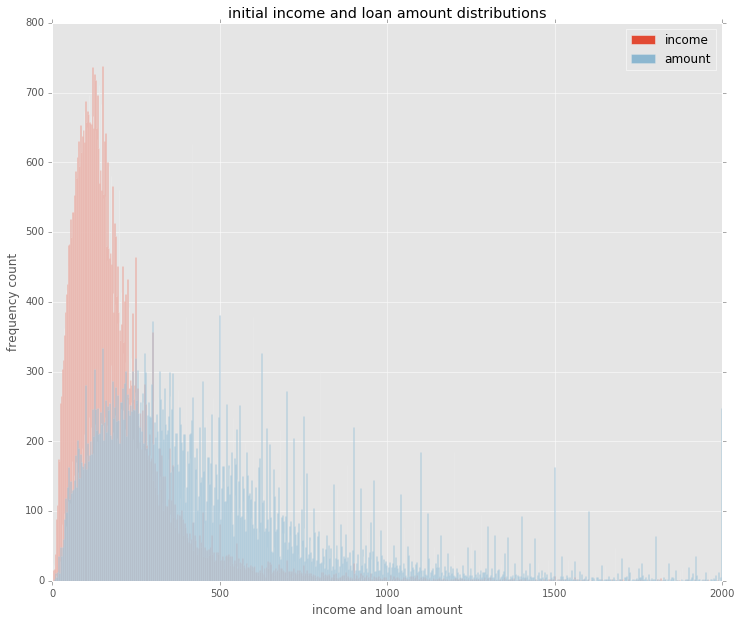

In [ ]:
#calculate descriptive stats
print(bank_df.amount.std(), 'std') 
print(bank_df.amount.mean(), 'mean') 
print(bank_df.amount.median(), 'median')
print(bank_df.mult.max(), 'max mult')
print(bank_df.mult.min(), 'min mult')
print(bank_df.amount.quantile(q=.98), '98%')
print(bank_df.amount.quantile(q=.75), 'q3')
print(bank_df.amount.quantile(q=.25), 'q1')
print(bank_df.amount.quantile(q=.02), '02%')
q1 = bank_df.amount.quantile(q=.25)
q3 = bank_df.amount.quantile(q=.75)
q98 = bank_df.amount.quantile(q=.98) #potential upper bound for quality
q2 = bank_df.amount.quantile(q=.02) #potential lower bound for quality
iqr =(q3 - q1)
print(iqr, 'iqr')
min_q = q1 - 1.5*iqr #potential lower bound for quality
max_q = q3 + 1.5*iqr #potential upper bound for quality
print(min_q, 'min_q', max_q, 'max_q')


amt = bank_df.amount #get data as series for graphing
inc = bank_df.income #get data as series for graphing
bins = np.linspace(0,2000, 1000) #set ranges and number of bins
bank_viz = plt.figure(figsize=(12,10)) #set plot size
plt.hist(inc, bins, label='income', alpha=1) #plot histogram of income
plt.hist(amt, bins, label='amount', alpha=.5) #plot histogram of loan amount
plt.legend(loc='upper right') #turn on legend and set location
plt.title('initial income and loan amount distributions')
plt.xlabel('income and loan amount')
plt.ylabel('frequency count')
plt.show()
#FIXME add 2 box plot viz

name 0 to 20
std 213.477507292
mean 131.583196046
median 77.0
max_mult 2500.0
med_mult 5.166666666666667
min_mult 1.05263157895
q98 711.6
q02 25.0
q75 129.5
q25 49.0
iqr 80.5
min_q -71.75
max_q 250.25
count of loans 607
pct of total loans 0.797016767552


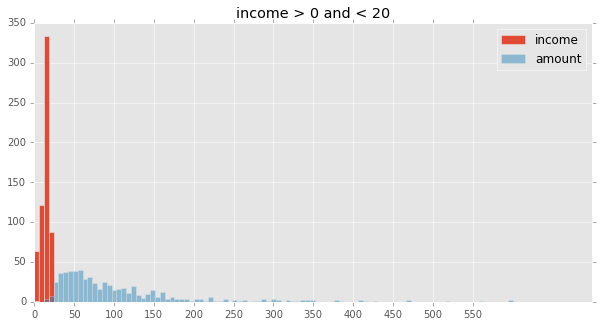

name 20 to 50
std 86.4857665915
mean 131.473161839
median 118.0
max_mult 38.4285714286
med_mult 3.347826086956522
min_mult 0.204081632653
q98 323.0
q02 26.72
q75 171.0
q25 74.0
iqr 97.0
min_q -71.5
max_q 316.5
count of loans 4937
pct of total loans 6.48249057892


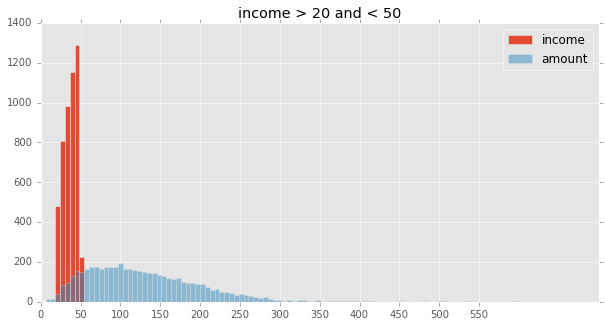

name 50 to 80
std 108.704813257
mean 200.6535077
median 190.5
max_mult 26.8070175439
med_mult 2.95832529423114
min_mult 0.119402985075
q98 424.0
q02 40.0
q75 265.0
q25 121.0
iqr 144.0
min_q -95.0
max_q 481.0
count of loans 8182
pct of total loans 10.7433133313


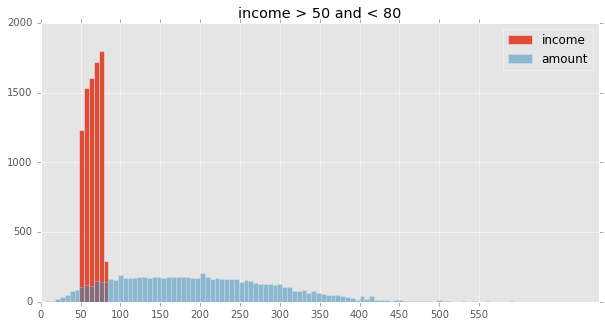

name 80 to 110
std 133.242905177
mean 268.880387709
median 255.0
max_mult 19.9
med_mult 2.7037037037037037
min_mult 0.103092783505
q98 559.06
q02 58.0
q75 353.0
q25 168.0
iqr 185.0
min_q -109.5
max_q 630.5
count of loans 9698
pct of total loans 12.7338856865


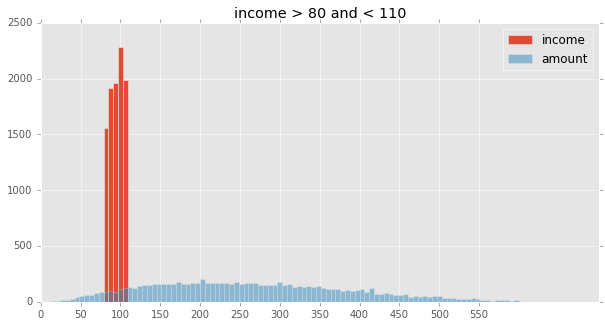

name 110 to 140
std 163.422483217
mean 341.19485805
median 322.0
max_mult 20.273381295
med_mult 2.593622967479675
min_mult 0.215517241379
q98 688.0
q02 80.0
q75 448.0
q25 218.25
iqr 229.75
min_q -126.375
max_q 792.625
count of loans 10074
pct of total loans 13.227589648


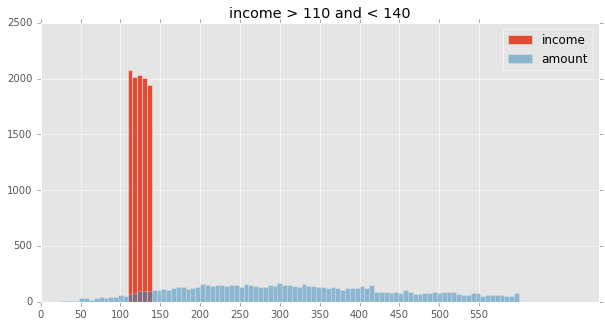

name 140 to 170
std 187.728882997
mean 410.352569986
median 386.0
max_mult 12.5384615385
med_mult 2.51242667489966
min_mult 0.0714285714286
q98 845.0
q02 106.3
q75 534.0
q25 271.0
iqr 263.0
min_q -123.5
max_q 928.5
count of loans 8716
pct of total loans 11.444478


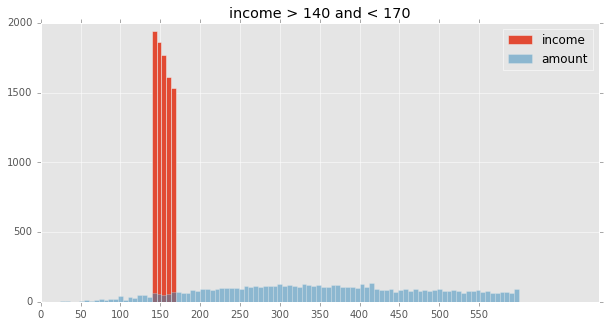

name 170 to 200
std 216.160479117
mean 472.150907771
median 448.0
max_mult 12.9888268156
med_mult 2.4324324324324325
min_mult 0.0899470899471
q98 980.0
q02 120.0
q75 603.0
q25 313.0
iqr 290.0
min_q -122.0
max_q 1038.0
count of loans 6885
pct of total loans 9.04029727281


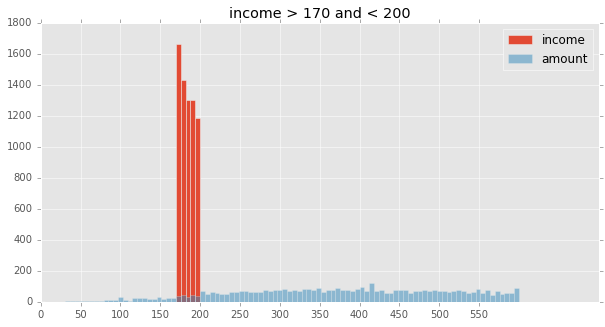

name 200 to 230
std 243.444268556
mean 541.450633815
median 513.0
max_mult 14.2718446602
med_mult 2.4158415841584158
min_mult 0.196078431373
q98 1119.0
q02 140.0
q75 680.0
q25 366.0
iqr 314.0
min_q -105.0
max_q 1151.0
count of loans 5601
pct of total loans 7.35435076616


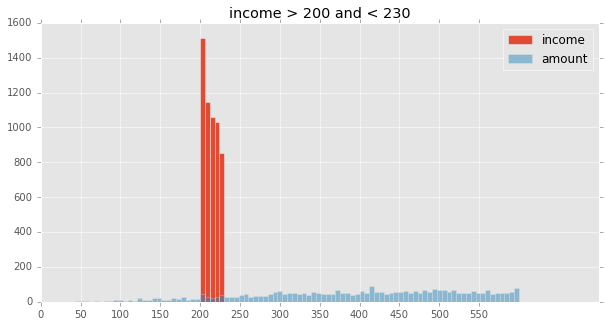

name 230 to 260
std 278.757795496
mean 611.803119349
median 579.5
max_mult 16.743697479
med_mult 2.368748263406502
min_mult 0.160642570281
q98 1294.54
q02 160.0
q75 756.0
q25 418.0
iqr 338.0
min_q -89.0
max_q 1263.0
count of loans 4424
pct of total loans 5.80889980173


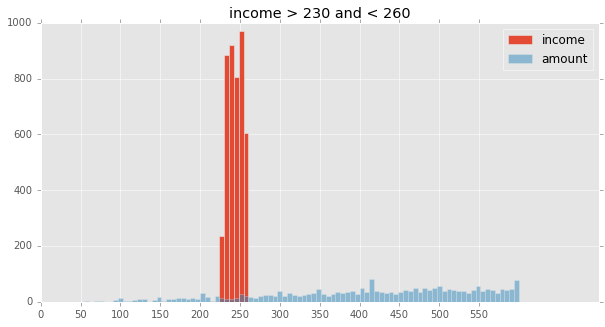

In [ ]:
#Cycle over different income bins and plot loan amount distribution for each
#focus on finding the best bins
#repeat for different SQL selection filters (junior liens, non-owner-occupied, VA/FHA/RHS loans, manufactured housing)
bin_min = 0
bin_max = 20
bin_step = 30
pct_of_loans = OrderedDict({})
first = True
while bin_max < 751:
    graph_bin = bank_df[(bank_df.income >=bin_min) & (bank_df.income < bin_max)] #create bin of of amount for selected income
    #set descriptive stats
    bin_stats = OrderedDict({})
    bin_stats['name'] = str(bin_min) + ' to ' + str(bin_max)
    bin_stats['std']= graph_bin.amount.std()
    bin_stats['mean'] = graph_bin.amount.mean()
    bin_stats['median'] = graph_bin.amount.median()
    bin_stats['max_mult'] = graph_bin.mult.max()
    bin_stats['med_mult'] = graph_bin.mult.median()
    bin_stats['min_mult'] = graph_bin.mult.min()
    bin_stats['q98'] = graph_bin.amount.quantile(q=.98)
    bin_stats['q02'] = graph_bin.amount.quantile(q=.02)
    bin_stats['q75'] = graph_bin.amount.quantile(q=.75)
    bin_stats['q25'] = graph_bin.amount.quantile(q=.25)
    bin_stats['iqr'] = bin_stats['q75'] - bin_stats['q25']
    bin_stats['min_q'] = bin_stats['q25'] - 1.5 * bin_stats['iqr']
    bin_stats['max_q'] = bin_stats['q75'] + 1.5 * bin_stats['iqr']
    bin_stats['count of loans'] = graph_bin.amount.count()
    bin_stats['pct of total loans'] = (graph_bin.amount.count() / bank_df.income.count()) * 100
    
    if first:
        first=False
        bin_df = pd.DataFrame(bin_stats, index=range(1))
    else:

        concat_df = pd.DataFrame(bin_stats, index=range(1))
        bin_df = pd.concat([bin_df, concat_df], axis=0)
    for key, value in bin_stats.items():
        print(key,value)
    
    amt = graph_bin.amount#.apply(sqrt)
    inc = graph_bin.income#.apply(sqrt) #square roots show much nicer distributions of amount to income
    xmin = 0 #set minimum x axis value
    xmax = 600 #set maximum x axis value
    xsteps= 100 #set steps on x axis (bins)
    bins = np.linspace(xmin,xmax, xsteps)
    #print(bins)
    bin_viz = plt.figure(figsize=(10,5))
    plt.hist(inc, bins, label='income', alpha=1)
    plt.hist(amt, bins, label='amount', alpha=.5)
    plt.title('income > '+str(bin_min)+' and < '+str(bin_max))
    plt.legend(loc='upper right')
    plt.xticks(np.arange(xmin,xmax, 50))
    ax = plt.subplot()
    #ax.set_ylim(0, 2000)
    plt.show(bin_viz)
    bin_min=bin_max
    bin_max += bin_step
    pct_of_loans[bin_max] = bin_stats['pct of total loans']
bin_df.reset_index(inplace=True)

In [ ]:
#graph percent of loans by top of income bin
y = []
x = []
for key, value in pct_of_loans.items():
    y.append(value)
    x.append(key)
plt.plot(x,y)


In [ ]:
#make data adjustments and calculate desc stat deltas and regraph
#use this work to refine income bins and associated loan amount distributions



In [ ]:
path = 'linked_dist_stats/'
if not os.path.exists(path):
    os.makedirs(path)
bin_df.to_csv(path+'no_mod.csv')

In [132]:
bin_df.head(100)

,index,name,std,mean,median,max_mult,med_mult,min_mult,q98,q02,q75,q25,iqr,min_q,max_q,count of loans,pct of total loans
0,0,0 to 20,213.477507,131.583196,77.0,2500.000000,5.166667,1.052632,711.60,25.00,129.50,49.00,80.50,-71.750,250.250,607,0.797017
1,0,20 to 50,86.485767,131.473162,118.0,38.428571,3.347826,0.204082,323.00,26.72,171.00,74.00,97.00,-71.500,316.500,4937,6.482491
2,0,50 to 80,108.704813,200.653508,190.5,26.807018,2.958325,0.119403,424.00,40.00,265.00,121.00,144.00,-95.000,481.000,8182,10.743313
3,0,80 to 110,133.242905,268.880388,255.0,19.900000,2.703704,0.103093,559.06,58.00,353.00,168.00,185.00,-109.500,630.500,9698,12.733886
4,0,110 to 140,163.422483,341.194858,322.0,20.273381,2.593623,0.215517,688.00,80.00,448.00,218.25,229.75,-126.375,792.625,10074,13.227590
5,0,140 to 170,187.728883,410.352570,386.0,12.538462,2.512427,0.071429,845.00,106.30,534.00,271.00,263.00,-123.500,928.500,8716,11.444478
6,0,170 to 200,216.160479,472.150908,448.0,12.988827,2.432432,0.089947,980.00,120.00,603.00,313.00,290.00,-122.000,1038.000,6885,9.040297
7,0,200 to 230,243.444269,541.450634,513.0,14.271845,2.415842,0.196078,1119.00,140.00,680.00,366.00,314.00,-105.000,1151.000,5601,7.354351
8,0,230 to 260,278.757795,611.803119,579.5,16.743697,2.368748,0.160643,1294.54,160.00,756.00,418.00,338.00,-89.000,1263.000,4424,5.808900
9,0,260 to 290,305.936647,673.588147,624.5,7.604563,2.278590,0.249110,1434.54,168.46,849.00,460.00,389.00,-123.500,1432.500,3324,4.364553


In [ ]:
#exclude data with quality edit fails